In [7]:
import sys, os
from itertools import cycle, product
from datetime import datetime, timedelta
from copy import copy
from osgeo import gdal, ogr
import numpy as np
import scipy.ndimage
import matplotlib
import matplotlib.pyplot as plt
import cookb_signalsmooth as sm
from pygeotools.lib import geolib, warplib, malib, timelib,iolib
from imview.lib import pltlib
import extractZ_csv

### Function for smoothing signal (uses scipy cookbook approach)

In [8]:
def smooth_z(z, win=5):
    z_sm = malib.nanfill(z, sm.smooth, win) 
    return z_sm

### Functions to extract pixel values at defined intervals along the profile line

In [9]:
def getZ(bma, gt, mX, mY):
    z = []
    #Extract pixel coordinates
    pX, pY = geolib.mapToPixel(np.array(mX), np.array(mY), gt)
    z = extractZ_csv.extractPoint(bma, pX, pY)
    return z
def getZ_map_coord(bma, gt, mX, mY):
    pX, pY = geolib.mapToPixel(np.array(mX), np.array(mY), gt)
    #scipy.ndimage.map_coordinates(bma, [pY, pX], mode='nearest', order=1)
    z = malib.nanfill(bma, scipy.ndimage.map_coordinates, [pY, pX], mode='nearest', order=1)
    return z

### Function for z_padding, not sure of it's use currently

In [10]:
def getZ_pad(bma, gt, mX, mY, pad=1):
    pX, pY = geolib.mapToPixel(np.array(mX), np.array(mY), gt)
    pX = np.ma.around(pX).astype(int)
    pY = np.ma.around(pY).astype(int)
    pX = np.clip(pX, 0, bma.shape[1] - 1)
    pY = np.clip(pY, 0, bma.shape[0] - 1)

    if pad == 0:
        z = bma[pY,pX]
    else:
        window_x = np.clip([pX-pad, pX+pad+1], 0, bma.shape[1]-1).astype(int)
        window_y = np.clip([pY-pad, pY+pad+1], 0, bma.shape[0]-1).astype(int)
        #print window_x
        #print window_y
        z = np.ma.masked_all_like(mX)
        for i in range(z.shape[0]):
            samp = bma[window_y[0][i]:window_y[1][i],window_x[0][i]:window_x[1][i]].reshape(np.ptp(window_x[:,i])*np.ptp(window_y[:,i]))
            #v = v.mean(axis=1)
            z[i] = np.ma.median(samp, axis=0)
    return z

### Arguments for profiles

In [11]:
#smooth = False
smooth = True
km = True 

#Shapefile
s_fn='mergelines.shp'
shp = ogr.Open(s_fn)
lyr = shp.GetLayer()
lyr_extent = lyr.GetExtent()
#Want xmin, ymin, xmax, ymax
lyr_extent = [lyr_extent[0], lyr_extent[2], lyr_extent[1], lyr_extent[3]]
#lyr_extent = ' '.join(str(x) for x in lyr_extent)
lyr.ResetReading()
nfeat = lyr.GetFeatureCount()


#Single Raster
fn1='Velocity_ma.tif' #Elevation_dataset, it is assumed that both the elevation and dh rasters are clipped to glacier extents
fn2='Hillshade.tif' ##Hillshade Raster for context figure
ds_list=warplib.memwarp_multi_fn([fn1,fn2],res='max',extent='intersection',t_srs='first', r='cubic')
A=iolib.ds_getma(ds_list[0])
#dh=iolib.ds_getma(ds_list[1])
E=np.ma.asarray(A,dtype=np.float32)
gt=ds_list[0].GetGeoTransform()
hs= iolib.ds_getma(ds_list[1])
#Sampling_distance
#dl=30
dl=geolib.get_res(ds_list[0])[0]
print dl
print gt


Warping all inputs to the following:
Resolution: 30.0
Extent: [594832.5, 3698542.5, 629212.5, 3753472.5]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 2: Velocity_ma.tif
2 of 2: Hillshade.tif
nl: 1831 ns: 1146 res: 30.000
30.0
(594832.5, 30.0, 0.0, 3753472.5, 0.0, -30.0)



Processing 1 of 4 input lines

Processing 2 of 4 input lines


/home/rs_lab/.conda/envs/my_himat_env/lib/python2.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.



Processing 3 of 4 input lines

Processing 4 of 4 input lines


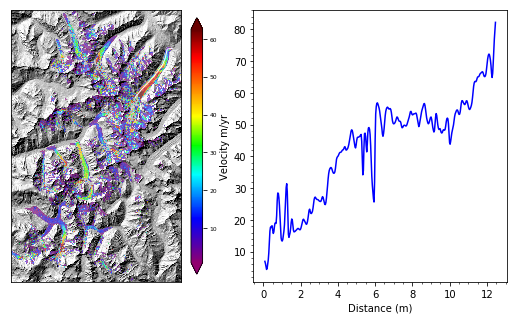

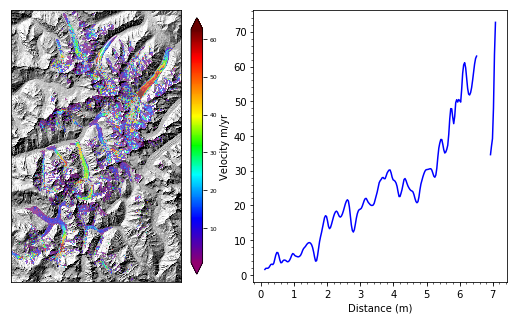

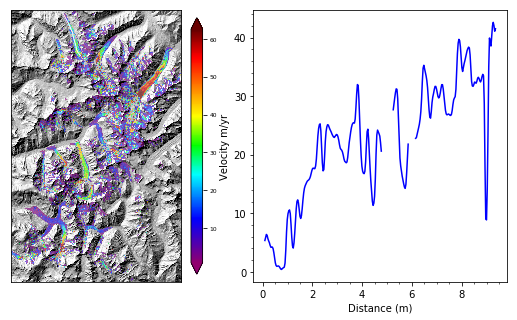

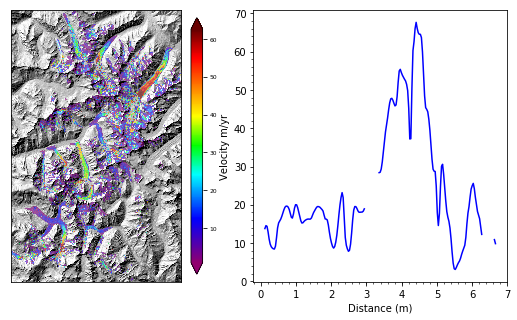

In [12]:
for n, feat in enumerate(lyr):
    print
    print "Processing %i of %i input lines" % (n+1, nfeat)
    fid = feat.GetFID()
    name = feat.GetFieldAsString(1)
    geom = feat.GetGeometryRef()
    #geom.GetPointCount()
    #geom.Length()
    #Return a nice list of points
    #nodes = geom.GetPoints()

    #Convert geom to equidistant

    l, mX, mY = geolib.line2pts(geom, dl)
    pX, pY = geolib.mapToPixel(np.array(mX), np.array(mY), gt)
    #Need to specify float here, as converting to km will reduce precision
    l = np.array(l, dtype=np.float32)
    if km:
        l /= 1000.
    

    z = getZ_map_coord(E, gt, mX, mY)
    if z.count() == 0:
            print "No valid values extracted"
    if smooth:
        z = smooth_z(z)
    #c, ls = next(linecycler)
    ls = 'solid'
    
    
    fig_frame = plt.figure(figsize=(10,5))
    #d_str = d.strftime('%Y-%m-%d %H:%M')
            #Add subplot with colored hillshade
    ax_im = fig_frame.add_subplot(121) 
    #ax_im.set_title(d_str)
    ax_im.set_axis_bgcolor('k')
            #hs = geolib.gdaldem_wrapper_ds(stack.ma_stack[m])
            #Note, the azimuths here appear to be relative to west
    alpha = 0.6
    ax_im.imshow(hs, cmap='gray', clim=malib.calcperc(hs, (2, 98)))
    clim = malib.calcperc(E, (2, 98))
    im = ax_im.imshow(E, cmap='cpt_rainbow', clim=clim, alpha=alpha)
    ax_im.plot(pX, pY, color='w', linestyle='-', linewidth=1, marker=None)
    pltlib.hide_ticks(ax_im)
    pltlib.add_cbar(ax_im, im, label=None)
    plt.autoscale(tight=True)
    #plt.tight_layout()
    ax_frame = fig_frame.add_subplot(122) 
    #ax_frame.set_title(d_str)
    ax_frame.set_xlabel('Distance (m)')
    ax_frame.set_ylabel('Velocity m/yr')
    pltlib.minorticks_on(ax_frame)
    c = 'b'
    ax_frame.plot(l, z, color=c, linestyle=ls)
    #plt.tight_layout()